# Prep my data for offline flux calculation

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

## Load merged, preprocessed atmos and ocean data

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Process data for future flux check

In [4]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

#take a sample of the earth for analysis
ds_highRes = ds_in.isel(time = slice(0,365))  
ds_highRes

<xarray.Dataset>
Dimensions:       (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Heat flux

### Offline Calculation

In [5]:
import aerobulk
from aerobulk import noskin

ql, qh, taux, tauy, evap =  noskin(
        ds_highRes.surface_temp,
        ds_highRes.t_ref,
        ds_highRes.q_ref,
        ds_highRes.u_relative,
        ds_highRes.v_relative,
        slp=ds_highRes.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatfluxHR = qh + ql
heatfluxHR

<xarray.DataArray (time: 365, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<add, shape=(365, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [23]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2) #default: n_workers=4, threads_per_worker=1
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/46663/status,
Dashboard: /user/panalluri/proxy/46663/status,Workers: 4
Total threads: 8,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39223,Workers: 4
Dashboard: /user/panalluri/proxy/46663/status,Total threads: 8
Started: Just now,Total memory: 125.80 GiB
Comm: tcp://127.0.0.1:41069,Total threads: 2
Dashboard: /user/panalluri/proxy/41993/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:39317,


In [6]:
# mask heat flux data

mask = ds_highRes.surface_temp > 273.14
masked_HF = heatfluxHR.where(mask)
masked_HF

<xarray.DataArray (time: 365, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<where, shape=(365, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [8]:
# prepare code for comparison w CM2.6 online flux
# weighted, masked average

HF_spatialAvg_masked = masked_HF.weighted(ds_merged.area_t).mean(dim=["xt_ocean", "yt_ocean"]).load()
HF_spatialAvg_masked

<xarray.DataArray (time: 365)> Size: 3kB
array([-119.63704379, -126.73165647, -127.01789349, -123.77705365,
       -126.45344653, -123.87044951, -121.19610358, -117.66459482,
       -115.82946134, -120.72900871, -121.05485216, -114.95575767,
       -112.50317138, -113.79647014, -120.13100032, -123.24088346,
       -123.00303085, -122.69945802, -118.26823614, -112.91515607,
       -112.03544087, -112.99653148, -117.78673413, -120.23662421,
       -121.33093208, -118.66329483, -115.50398694, -115.7244759 ,
       -118.80734099, -118.96153343, -116.91821115, -113.22124639,
       -113.00470519, -113.36474077, -111.06551539, -112.62742912,
       -111.62492246, -111.66819477, -112.75508029, -114.37842395,
       -113.9064185 , -115.41457329, -113.26850914, -111.15767249,
       -110.74829912, -113.29681906, -115.75268364, -117.93266023,
       -120.77753843, -117.4832457 , -113.66044382, -110.29347769,
       -109.40159336, -108.81170236, -111.7419802 , -111.1220121 ,
       -111.55479251, -113.89233793, -111.59614939, -112.4063917 ,
       -116.30212238, -118.47880987, -117.66389847, -117.14463223,
       -114.7081629 , -111.76789364, -109.77351708, -107.76472826,
       -107.3446484 , -112.29751599, -115.88245603, -112.52510879,
       -108.3721451 , -103.30611169, -105.29695976, -113.18295523,
       -116.27123338, -117.26419979, -117.09817909, -119.20757274,
...
       -115.65058706, -115.78922402, -113.17777422, -111.16665674,
       -110.08989665, -109.70134118, -113.62098327, -119.73003603,
       -120.29880289, -119.28791914, -118.02668049, -118.99919586,
       -121.89452516, -120.31603294, -114.24618118, -113.35000268,
       -118.79393209, -118.01157723, -113.7317594 , -113.47292757,
       -114.76471663, -118.61219866, -122.65051196, -121.01291962,
       -116.89409944, -115.77659587, -117.00314392, -119.3489006 ,
       -121.60402204, -118.84327329, -120.58357204, -118.49964083,
       -117.73377928, -114.80899076, -115.95042669, -115.77330364,
       -112.70824176, -112.57184936, -117.46974369, -119.48937806,
       -119.2084848 , -117.14681561, -119.96625234, -117.99905835,
       -114.66143739, -113.89835422, -114.41420671, -111.79798881,
       -111.15869201, -118.13929759, -124.32713209, -124.0750947 ,
       -122.80747309, -120.81993426, -119.32180628, -118.3113043 ,
       -114.44677051, -117.4697333 , -118.38672882, -115.55819895,
       -116.09435601, -114.24302888, -111.49034543, -111.44186731,
       -116.37273168, -122.34146624, -120.33064893, -115.87745541,
       -116.51498519, -116.49186397, -114.81043248, -115.50438041,
       -116.9934043 , -118.75095939, -119.0880217 , -118.74264742,
       -119.36544016])
Coordinates:
  * time     (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00

### Online flux comparison

In [9]:
# CM2.6 grid info --> gives t-cell and u-cell areas!

from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_grid  = cat["GFDL_CM2_6_grid"].to_dask()
ds_grid

<xarray.Dataset>
Dimensions:         (yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                     xu_ocean: 3600, st_edges_ocean: 51, st_ocean: 50,
                     sw_edges_ocean: 51, sw_ocean: 50)
Coordinates: (12/27)
    area_t          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_u          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxu             (yu_ocean, xu_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyu             (yu_ocean, xu_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...              ...
  * sw_ocean        (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
    wet             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables:
    *empty*
Attributes:
    NCO:      4.0.3

In [10]:
from CM26_fluxes import get_params
from CM26_fluxes import add_total

label_dict = {
    "ql": "Latent Heatflux [$W/m^2$]",
    "qh": "Sensible Heatflux [$W/m^2$]",
    "q_total": "Turbulent Heatflux\n(Sensible + Latent) [$W/m^2$]",
}

params = get_params("v1.0.1", test=False)
models = ["CM26", "CESM"]
open_kwargs = dict(
    engine="zarr",
    chunks={},
)

max_ice_mask = {}
path = params["paths"]["CM26"]["plotting"]["max_ice_mask"]
da = xr.open_dataset(path, **open_kwargs).max_extent_ice_mask
max_ice_mask["CM26"] = da

# full flux output
full_flux = {}
for model in models:
    full_flux[model] = {}
    for computed in ["online", "offline"]:
        full_flux[model][computed] = {}
        for mean in ["time_mean", "global_mean"]:
            path = params["paths"][model]["plotting"]["full_fluxes"][computed][mean]
            ds = xr.open_dataset(path, **open_kwargs)
            full_flux[model][computed][mean] = ds

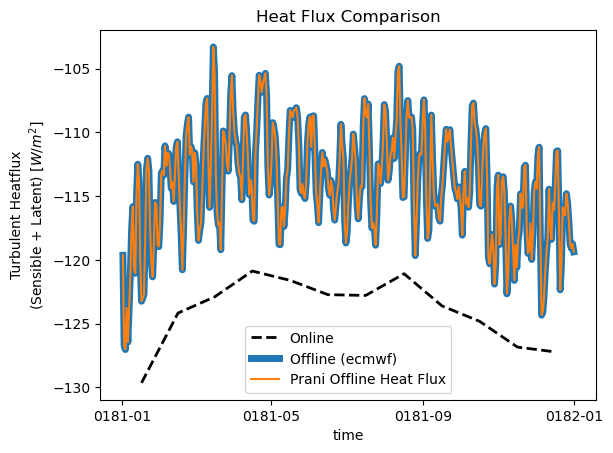

In [18]:
fig, ax = plt.subplots()

ds = full_flux["CM26"]["online"]["global_mean"]
da = add_total(ds)["q_total"]
da.plot(label="Online", ax=ax, lw=2, ls="--", color="k")

ds_offline = full_flux["CM26"]["offline"]["global_mean"]
da_offline = add_total(ds_offline)["q_total"]
da_offline.sel(algo='ecmwf').plot(label=f"Offline ({'ecmwf'})", ax=ax, linewidth=5)

HF_spatialAvg_masked.plot(label='Prani Offline Heat Flux', ax=ax)

ax.set_title("Heat Flux Comparison")
ax.set_ylabel(label_dict["q_total"])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")


#### Plotting my fluxes against online heat fluxes

In [21]:
#online fluxes

path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
ds = xr.open_dataset(path, engine='zarr', chunks={})
ds

<xarray.Dataset>
Dimensions:                    (time: 240, yu_ocean: 2700, xu_ocean: 3600,
                                yt_ocean: 2700, xt_ocean: 3600, nv: 2)
Coordinates:
    geolat_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                         (nv) float64 1.0 2.0
  * time                       (time) object 0181-01-16 12:00:00 ... 0200-12-...
  * xt_ocean                   (xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
  * xu_ocean                   (xu_ocean) float64 -279.9 -279.8 ... 79.9 80.0
  * yt_ocean                   (yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98
  * yu_ocean                   (yu_ocean) float64 -81.09 -81.05 ... 89.96 90.0
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

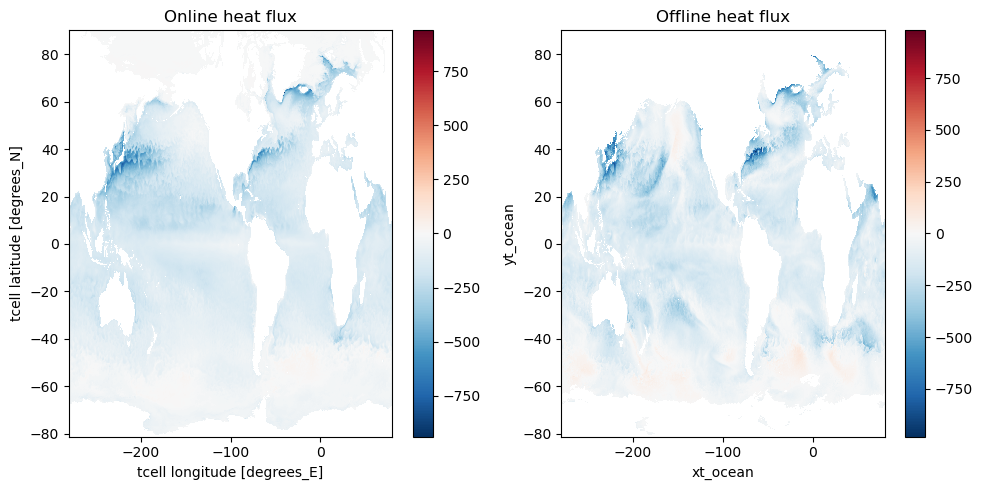

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

online_HF = ds.sens_heat + ds.evap_heat
online_HF.isel(time=0).plot(ax=ax1)
ax1.set_title('Online heat flux')

# Plot data on the second subplot
masked_HF.isel(time=0).plot(ax=ax2)
ax2.set_title('Offline heat flux')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#### Hovmöller diagram

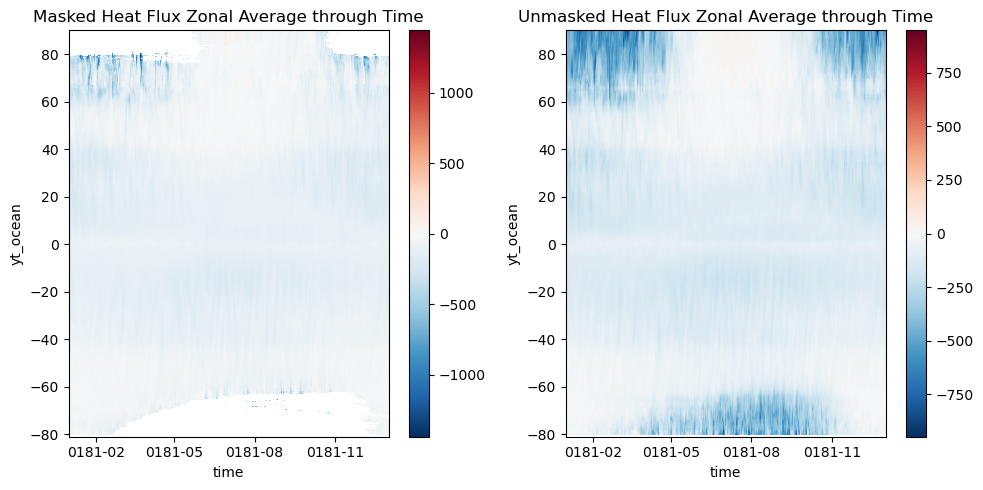

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

masked_HF_zonalAvg = masked_HF.weighted(ds_grid.area_t).mean(dim="xt_ocean")
masked_HF_zonalAvg.transpose().plot(ax=ax1)
ax1.set_title('Masked Heat Flux Zonal Average through Time')

# Plot data on the second subplot
masked_HF_zonalAvg = heatfluxHR.weighted(ds_grid.area_t).mean(dim="xt_ocean")
masked_HF_zonalAvg.transpose().plot(ax=ax2)
ax2.set_title('Unmasked Heat Flux Zonal Average through Time')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Momentum flux

### Offline calculation

In [66]:
# weighted spatial average

momfluxHR = np.sqrt( (taux ** 2 + tauy ** 2) )
masked_MF = momfluxHR.where(mask)

MF_spatialAvg_masked = masked_MF.weighted(ds_merged.area_t).mean(dim=["xt_ocean", "yt_ocean"]).load()
MF_spatialAvg_masked

<xarray.DataArray (time: 365)> Size: 3kB
array([0.10336019, 0.11565161, 0.11590227, 0.11133496, 0.11426608,
       0.11547093, 0.11169309, 0.10838928, 0.10632679, 0.10953791,
       0.10998678, 0.10534301, 0.09581751, 0.09237503, 0.10313303,
       0.10638352, 0.11119111, 0.11189657, 0.10547086, 0.09550976,
       0.09260439, 0.09878672, 0.10627627, 0.11305319, 0.11568046,
       0.11168562, 0.10534386, 0.10157624, 0.10068186, 0.10505352,
       0.10806629, 0.10177133, 0.09861317, 0.10132494, 0.09923246,
       0.09469175, 0.0931371 , 0.09645641, 0.09902316, 0.10620655,
       0.10677879, 0.1040395 , 0.10035281, 0.09687376, 0.09860837,
       0.09919051, 0.10245743, 0.11063106, 0.11674402, 0.11320786,
       0.10451004, 0.09780594, 0.09478569, 0.09530805, 0.10009389,
       0.0925511 , 0.09333791, 0.09837604, 0.09959844, 0.10310322,
       0.10333389, 0.10524998, 0.10523109, 0.11148765, 0.11255396,
       0.10492953, 0.10005544, 0.1051508 , 0.10454961, 0.11388511,
       0.11483729, 0.11089754, 0.10664801, 0.10017783, 0.09822892,
       0.10010685, 0.10122944, 0.10485261, 0.10637091, 0.10602748,
       0.09918474, 0.09409404, 0.09729191, 0.10248645, 0.10374033,
       0.10566735, 0.10150298, 0.09806333, 0.09466673, 0.09258809,
       0.09230764, 0.09912622, 0.09827546, 0.09924239, 0.09942112,
       0.10304241, 0.10632999, 0.10479062, 0.10192545, 0.10144643,
...
       0.10653219, 0.10383072, 0.10478674, 0.101549  , 0.10132781,
       0.09999923, 0.1016726 , 0.11159303, 0.11143542, 0.10582258,
       0.10309976, 0.10126538, 0.10298526, 0.10828607, 0.11465033,
       0.109567  , 0.10079795, 0.09896947, 0.09464358, 0.09066761,
       0.08946191, 0.08777465, 0.09065469, 0.10200742, 0.10672097,
       0.10227999, 0.09462252, 0.09391477, 0.0956318 , 0.10067859,
       0.11079533, 0.11009004, 0.11022469, 0.10858392, 0.10980357,
       0.11559799, 0.11722353, 0.10562459, 0.10147453, 0.10533197,
       0.1013064 , 0.09253115, 0.09122671, 0.09591049, 0.09710612,
       0.10169302, 0.10545797, 0.09763588, 0.09520004, 0.09332866,
       0.09583954, 0.09859401, 0.10061287, 0.10366148, 0.097132  ,
       0.09392379, 0.09121822, 0.09333861, 0.09612147, 0.09745895,
       0.09338136, 0.10096779, 0.10395883, 0.10301483, 0.09855182,
       0.10601044, 0.10344324, 0.0965593 , 0.09282203, 0.09517696,
       0.09563615, 0.0950081 , 0.09636584, 0.09849038, 0.09990126,
       0.10680038, 0.10962288, 0.10692109, 0.10458094, 0.10394768,
       0.10724133, 0.11137496, 0.1094733 , 0.10841967, 0.10350019,
       0.09985885, 0.09587393, 0.09850618, 0.1083145 , 0.10265378,
       0.09987657, 0.10433746, 0.10417479, 0.10328621, 0.10090527,
       0.09901035, 0.10270826, 0.10560321, 0.10407529, 0.10735813])
Coordinates:
  * time     (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00

### Online comparison

In [42]:
# online weighted average

MomF_CM26 = np.sqrt( ds.tau_x ** 2 + ds.tau_y ** 2 )    
MF_CM26 = MomF_CM26.weighted(ds_grid.area_u).mean(dim=["xu_ocean", "yu_ocean"]).load()
MF_CM26 = MF_CM26.isel(time=slice(0,12))
MF_CM26

<xarray.DataArray (time: 12)> Size: 48B
array([0.08405783, 0.08045803, 0.07677883, 0.07150153, 0.07328419,
       0.08113401, 0.08807004, 0.08329608, 0.0856967 , 0.08325595,
       0.07127456, 0.07831601], dtype=float32)
Coordinates:
  * time     (time) object 96B 0181-01-16 12:00:00 ... 0181-12-16 12:00:00

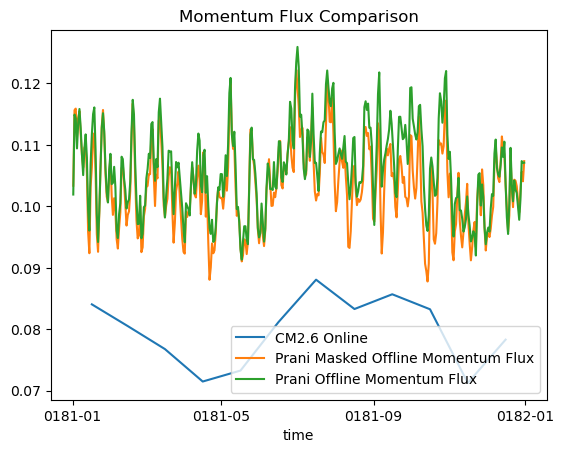

In [27]:
fig, ax = plt.subplots()

MF_CM26.plot(label=f"CM2.6 Online", ax=ax) 

MF_spatialAvg_masked.to_dataarray().plot(label='Prani Masked Offline Momentum Flux', ax=ax)
MF_spatialAvg.to_dataarray().plot(label='Prani Offline Momentum Flux', ax=ax)

ax.set_title("Momentum Flux Comparison")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")

In [52]:
taux_oneMonthAvg = taux.isel(time=slice(0,30)).mean(dim='time')
tauy_oneMonthAvg = tauy.isel(time=slice(0,30)).mean(dim='time')
momfluxHR_oneMonthAvg = np.sqrt( (taux_oneMonthAvg ** 2 + tauy_oneMonthAvg ** 2) )
momfluxHR_oneMonthAvg

<xarray.DataArray (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
dask.array<where, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

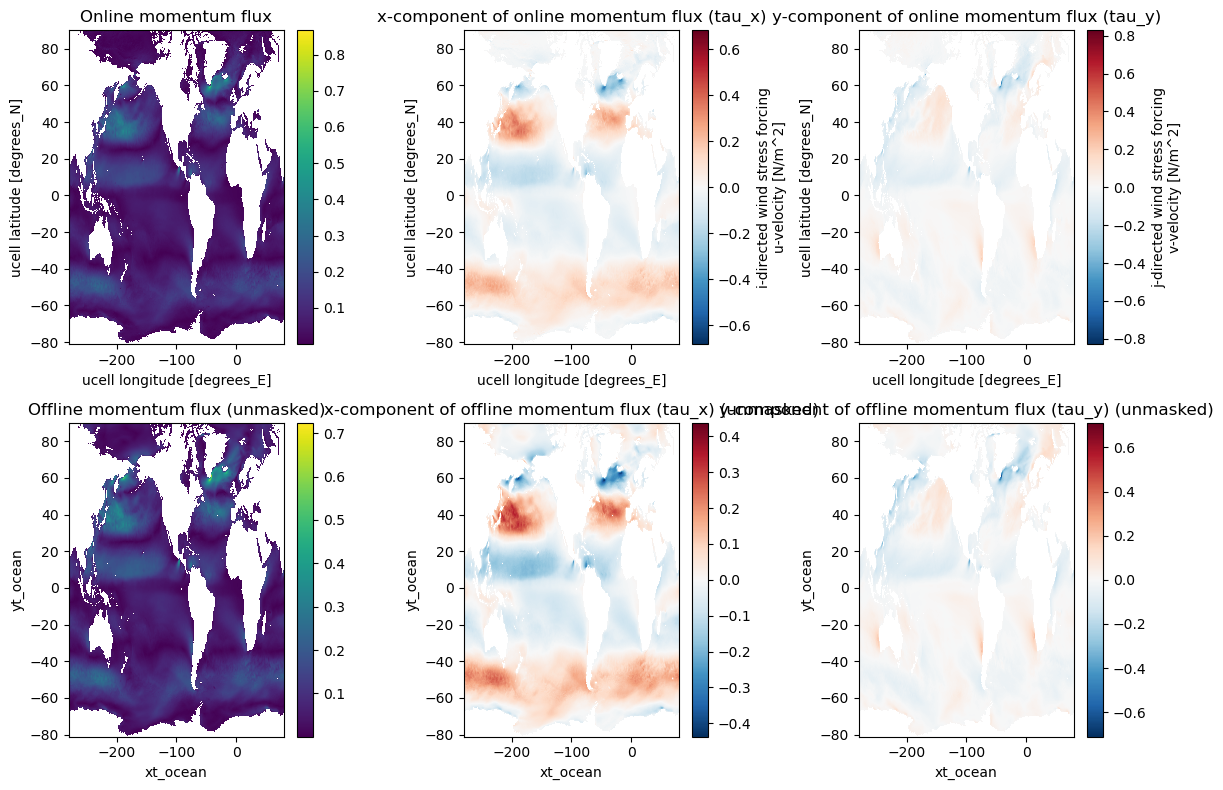

In [62]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))

MomF_CM26.isel(time=0).plot(ax=ax1)
ax1.set_title('Online momentum flux')

ds.tau_x.isel(time=0).plot(ax=ax2)
ax2.set_title('x-component of online momentum flux (tau_x)')

ds.tau_y.isel(time=0).plot(ax=ax3)
ax3.set_title('y-component of online momentum flux (tau_y)')

momfluxHR_oneMonthAvg.plot(ax=ax4)
ax4.set_title('Offline momentum flux (unmasked)')

taux_oneMonthAvg.plot(ax=ax5)
ax5.set_title('x-component of offline momentum flux (tau_x) (unmasked)')

tauy_oneMonthAvg.plot(ax=ax6)
ax6.set_title('y-component of offline momentum flux (tau_y) (unmasked)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

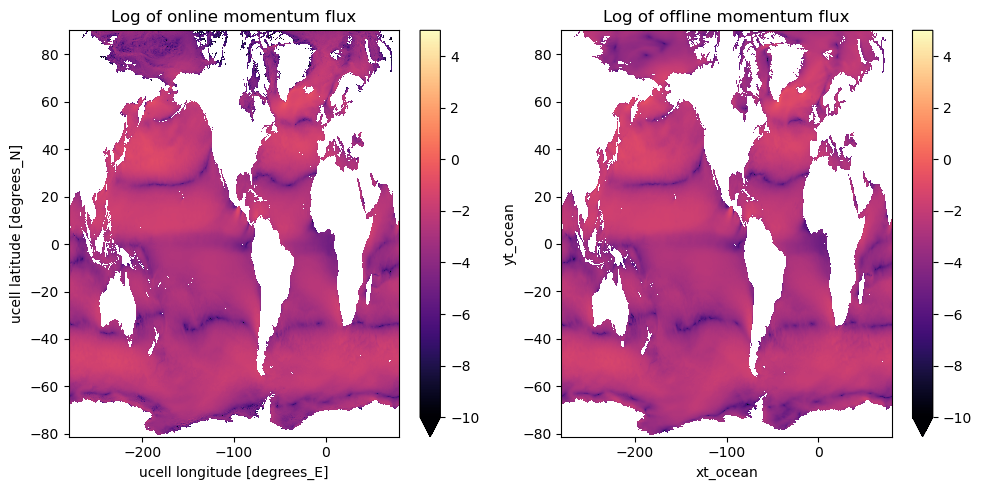

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

np.log(MomF_CM26.isel(time=0)).plot(vmin=-10, vmax=5, ax=ax1, cmap='magma')
ax1.set_title('Log of online momentum flux')

# Plot data on the second subplot
np.log(momfluxHR_oneMonthAvg).plot(vmin=-10, vmax=5, ax=ax2, cmap='magma')
ax2.set_title('Log of offline momentum flux')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#### Hovmöller diagram

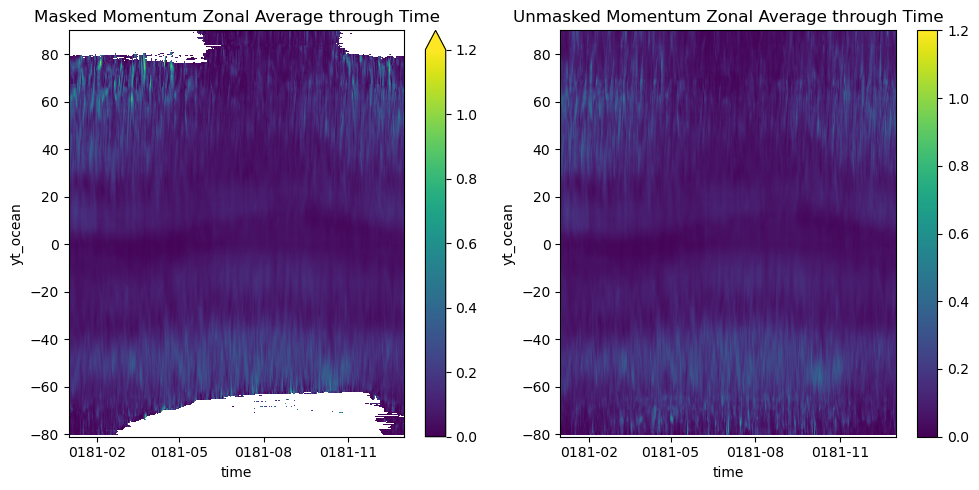

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

masked_MF_zonalAvg = masked_MF.weighted(ds_grid.area_t).mean(dim="xt_ocean")
masked_MF_zonalAvg.to_dataarray().transpose().plot(vmin=0, vmax=1.2, ax=ax1)
ax1.set_title('Masked Momentum Zonal Average through Time')

# Plot data on the second subplot
masked_MF_zonalAvg = momFluxHR.weighted(ds_grid.area_t).mean(dim="xt_ocean")
masked_MF_zonalAvg.to_dataarray().transpose().plot(vmin=0, vmax=1.2, ax=ax2)
ax2.set_title('Unmasked Momentum Zonal Average through Time')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Freshwater flux

### Offline calculation

In [15]:
# masked, weighted spatial average

masked_FF = evap.where(mask)

FF_spatialAvg_masked = masked_FF.weighted(ds_merged.area_t).mean(dim=["xt_ocean", "yt_ocean"]).load()
FF_spatialAvg_masked

In [18]:
# unmasked weighted spatial average

FF_spatialAvg = evap.weighted(ds_merged.area_t).mean(dim=["xt_ocean", "yt_ocean"]).load()
FF_spatialAvg

<xarray.Dataset> Size: 6kB
Dimensions:                        (time: 365)
Coordinates:
  * time                           (time) object 3kB 0181-01-01 12:00:00 ... ...
Data variables:
    __xarray_dataarray_variable__  (time) float64 3kB -3.946e-05 ... -3.919e-05

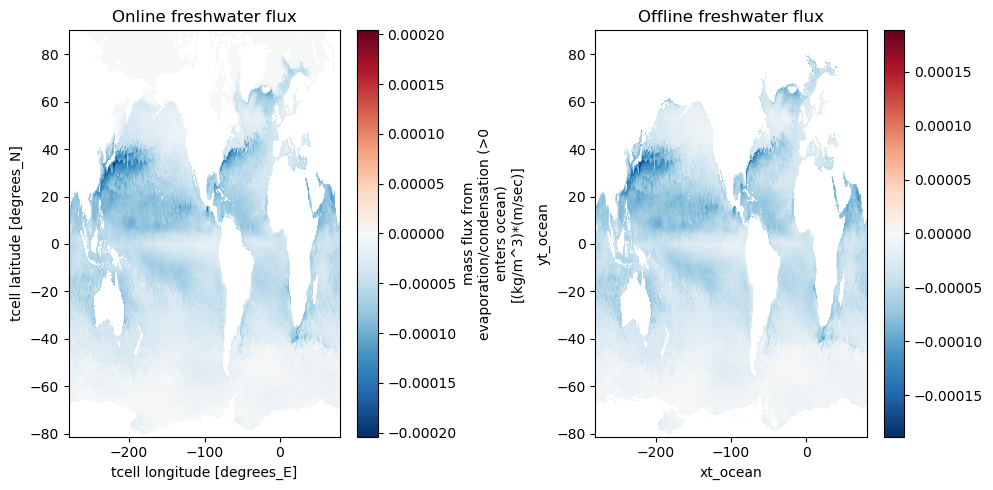

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ds.evap.isel(time=0).plot(ax=ax1)
ax1.set_title('Online freshwater flux')

masked_FF.isel(time=slice(0,30)).mean(dim='time').plot(ax=ax2)
ax2.set_title('Offline freshwater flux')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Online calculation

In [22]:
# online weighted spatial average

FF_CM26 = ds.evap.weighted(ds_grid.area_t).mean(dim=["xt_ocean", "yt_ocean"]).load()
FF_CM26 = FF_CM26.isel(time=slice(0,12))
FF_CM26

<xarray.DataArray 'evap' (time: 12)> Size: 48B
array([-4.2519274e-05, -4.1055726e-05, -4.0732826e-05, -4.0038442e-05,
       -4.0170202e-05, -4.0371833e-05, -4.0152099e-05, -3.9263108e-05,
       -3.9821327e-05, -3.9925118e-05, -4.0542309e-05, -4.1313222e-05],
      dtype=float32)
Coordinates:
  * time     (time) object 96B 0181-01-16 12:00:00 ... 0181-12-16 12:00:00

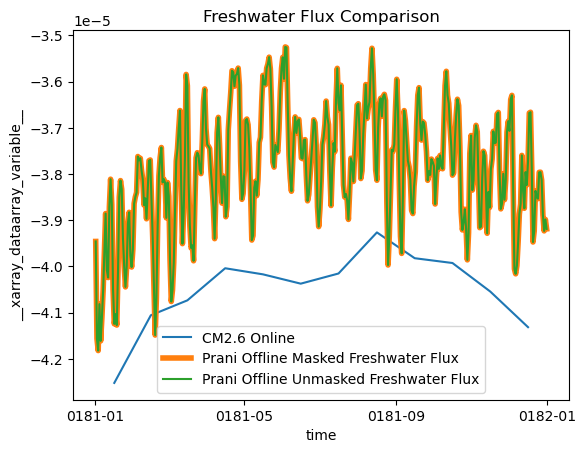

In [55]:
fig, ax = plt.subplots()

FF_CM26.plot(label=f"CM2.6 Online", ax=ax) 

FF_spatialAvg_masked.__xarray_dataarray_variable__.plot(label='Prani Offline Masked Freshwater Flux', ax=ax, linewidth=4)

FF_spatialAvg.__xarray_dataarray_variable__.plot(label='Prani Offline Unmasked Freshwater Flux', ax=ax)

ax.set_title("Freshwater Flux Comparison")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")


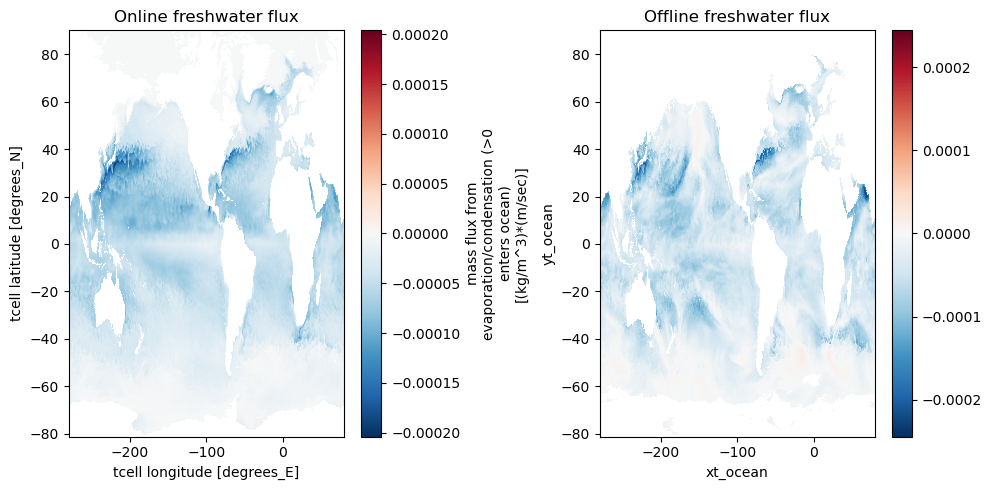

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ds.evap.isel(time=0).plot(ax=ax1)
ax1.set_title('Online freshwater flux')

# Plot data on the second subplot
masked_FF.isel(time=0).plot(ax=ax2)
ax2.set_title('Offline freshwater flux')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#### Hovmöller diagram

NameError: name 'ds' is not defined

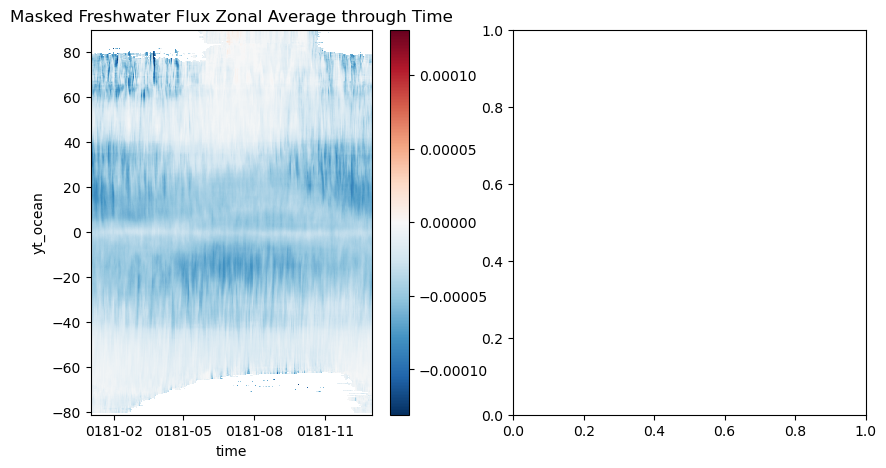

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

masked_FF_zonalAvg = masked_FF.weighted(ds_grid.area_t).mean(dim="xt_ocean")
masked_FF_zonalAvg.transpose().plot(ax=ax1)
ax1.set_title('Masked Freshwater Flux Zonal Average through Time')

# Plot data on the second subplot
masked_FF_zonalAvg = ds.evap.weighted(ds_grid.area_t).mean(dim="xt_ocean")
masked_FF_zonalAvg.transpose().plot(ax=ax2)
ax2.set_title('Unmasked Freshwater Flux Zonal Average through Time')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

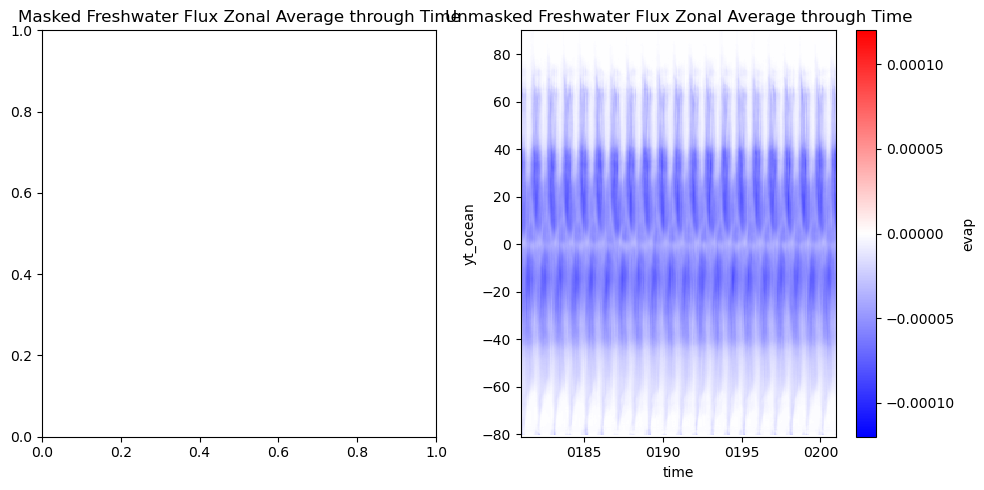

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('Masked Freshwater Flux Zonal Average through Time')

# Plot data on the second subplot
masked_FF_zonalAvg = ds.evap.weighted(ds_grid.area_t).mean(dim="xt_ocean")
masked_FF_zonalAvg.transpose().plot(vmin=-0.00012, vmax=0.00012, ax=ax2, cmap='bwr')
ax2.set_title('Unmasked Freshwater Flux Zonal Average through Time')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()